In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pyodbc
import datetime
from dateutil.relativedelta import relativedelta
import pymysql
from collections import defaultdict
from retag import retag
import calendar
import cx_Oracle



pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# AO CANADA

In [103]:
import cx_Oracle

Oracleconn = cx_Oracle.connect('APPSREAD/APPS4756@mundb11.munchkinsys.com/prd')

sql = '''

select 
to_char(ol.promise_date,'YYYY-MM')"MONTH",
hca.account_number "ACCT #",
inv.segment1 "ITEM",
inv.description "DESC",
hp.party_name "CUSTOMER",
OL.ORDER_QUANTITY_UOM "UOM",    
INV.ATTRIBUTE10 "CASE SIZE",    
DECODE(OL.ORDER_QUANTITY_UOM, 'EA' ,SUM(OL.ordered_quantity),SUM(OL.ordered_quantity)*INV.ATTRIBUTE10) + DECODE(OL.ORDER_QUANTITY_UOM, 'EA' ,SUM(OL.cancelled_quantity),SUM(OL.cancelled_quantity)*INV.ATTRIBUTE10) AS "ORDERED UNITS" 

from 
apps.oe_order_headers_all oh, 
apps.oe_order_lines_all ol,
apps.mtl_system_items_b inv,
--wsh_delivery_details wdd,
apps.hz_cust_accounts_all hca, 
apps.hz_parties hp

where 
oh.header_id = ol.header_id
and
inv.inventory_item_id = ol.inventory_item_id
and
inv.organization_id = 82
and
ol.ship_from_org_id in ('269','169', '512')
and
oh.sold_to_org_id = hca.cust_account_id
and
hca.party_id = hp.party_id
and
ol.promise_date between  to_date('2018/01/01', 'yyyy/mm/dd') and to_date('2021/12/31', 'yyyy/mm/dd')
and oh.order_type_id  not in ('1013','1015')
and hca.account_number not in ('36329',
'9565',
'8020',
'9197',
'43847',
'7963',
'1554') 

group by 
to_char(ol.promise_date,'YYYY-MM'),
hca.account_number, 
hp.party_name,
inv.segment1,
OL.ORDER_QUANTITY_UOM,
INV.ATTRIBUTE10,
inv.description
order by 3 desc

'''


conversion = pd.read_sql(sql,Oracleconn)

query = conversion.copy()
query.sample(2)

,MONTH,ACCT #,ITEM,DESC,CUSTOMER,UOM,CASE SIZE,ORDERED UNITS
7882,2020-10,20375,37298,SOFT SPOT CUSHIONED BATH MAT,ROSE OU BLEU,CS,6,6.0
15329,2018-01,3604-D,15973,1PK 9OZ PP CL INS STRW CUP,SAMPLES,CS,12,24.0


---

### About the Data


In [104]:
print(query.info())

print(query.shape)

for col in query.columns: 
    print(col) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21401 entries, 0 to 21400
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MONTH          21401 non-null  object 
 1   ACCT #         21401 non-null  object 
 2   ITEM           21401 non-null  object 
 3   DESC           21401 non-null  object 
 4   CUSTOMER       21401 non-null  object 
 5   UOM            21401 non-null  object 
 6   CASE SIZE      21401 non-null  object 
 7   ORDERED UNITS  21401 non-null  float64
dtypes: float64(1), object(7)
memory usage: 1.3+ MB
None
(21401, 8)
MONTH
ACCT #
ITEM
DESC
CUSTOMER
UOM
CASE SIZE
ORDERED UNITS


### Filter the data to contain just year=2020

In [105]:

df = query[query["MONTH"].isin(['2020-01','2020-02','2020-03','2020-04','2020-05',
                                '2020-06','2020-07','2020-08','2020-09','2020-10','2020-11','2020-12',
                               '2021-01','2021-02'])]      
df.sample(3)   

,MONTH,ACCT #,ITEM,DESC,CUSTOMER,UOM,CASE SIZE,ORDERED UNITS
3522,2020-06,3355,44198,COLOR BUDDIES-WHALE/PUFFER,"MUNCHKIN, INC.",CS,12,1500.0
12338,2020-08,34468,17959A,LUNCH BENTO BOX-GRN,WELL.CA INC,CS,6,12.0
15916,2020-11,0000,15806,3pk Lift Infant Spoons,Customer Satisfaction Replacement,EA,1,1.0


### Total order 2020 by Customer Name

In [106]:
TotalOrder = df.groupby('CUSTOMER').sum()
TotalOrder.sort_index(ascending=False)

,ORDERED UNITS
CUSTOMER,
WINNERS MERCHANTS INTL LP,41527.0
WELL.CA INC,27566.0
WADE ENTERPRISES LTD. / COUNTRY STORE,0.0
VARIÉTÉS JFR INC,581.0
UNIVERSAL DIAPERS,443.0
TJS THE KIDDIE STORE LTD.,2386.0
THE NORTH WEST COMPANY LP,18318.0
SONNIE ALBERT GIROUX,133.0
SOBEYS INC,4632.0


### Pivot 

In [107]:
#2020 order units by customer 
table = pd.pivot_table(df,index=['CUSTOMER'],columns=['MONTH'],values=['ORDERED UNITS'],aggfunc=np.sum)
table.sample(2)

ORDERED UNITS                                                                                                        
MONTH                                 2020-01 2020-02 2020-03 2020-04 2020-05 2020-06 2020-07 2020-08 2020-09 2020-10 2020-11 2020-12 2021-01 2021-02
CUSTOMER                                                                                                                                             
UNIVERSAL DIAPERS                         NaN     NaN     NaN     NaN     NaN     NaN     NaN   201.0    57.0     NaN     NaN     NaN   185.0     NaN
ONCE UPON A CHILD-ST CATHARINES           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   266.0     NaN     NaN     NaN     NaN

### See the order units by Item Number and Customer Number

#### Plug in Item Number to search

In [116]:
df3 = df[df["ITEM"].isin(['24030001'])]

#### Total Order Units grouped by Customer Name 

In [117]:
see_item_by_customer = df3.groupby('CUSTOMER').sum()

see_item_by_customer

,ORDERED UNITS
CUSTOMER,
PROMOTIONS C.D. INC.,60.0


#### Total Order Units grouped by Customer and Month

In [118]:
see_item_by_customer_and_item = df3.groupby(['CUSTOMER', 'MONTH']).sum()

see_item_by_customer_and_item

ORDERED UNITS
CUSTOMER             MONTH                 
PROMOTIONS C.D. INC. 2020-05           12.0
                     2020-07           12.0
                     2020-10           24.0
                     2020-12           12.0

#### Pivot4

In [119]:
see_item_by_customer_and_item_pivot = pd.pivot_table(df3,index=['CUSTOMER'],columns=['MONTH'],values=['ORDERED UNITS'],aggfunc=np.sum)

see_item_by_customer_and_item_pivot.sort_index(ascending=False)

ORDERED UNITS                        
MONTH                      2020-05 2020-07 2020-10 2020-12
CUSTOMER                                                  
PROMOTIONS C.D. INC.          12.0    12.0    24.0    12.0

----

# AO US 

In [83]:
import cx_Oracle

Oracleconn = cx_Oracle.connect('APPSREAD/APPS4756@mundb11.munchkinsys.com/prd')

sql = '''

select 
to_char(ol.promise_date,'YYYY-MM')"MONTH",
hca.account_number "ACCT #",
inv.segment1 "ITEM",
inv.description "DESC",
hp.party_name "CUSTOMER",
OL.ORDER_QUANTITY_UOM "UOM",    
INV.ATTRIBUTE10 "CASE SIZE",    
DECODE(OL.ORDER_QUANTITY_UOM, 'EA' ,SUM(OL.ordered_quantity),SUM(OL.ordered_quantity)*INV.ATTRIBUTE10) + DECODE(OL.ORDER_QUANTITY_UOM, 'EA' ,SUM(OL.cancelled_quantity),SUM(OL.cancelled_quantity)*INV.ATTRIBUTE10) AS "ORDERED UNITS" 

from 
apps.oe_order_headers_all oh, 
apps.oe_order_lines_all ol,
apps.mtl_system_items_b inv,
--wsh_delivery_details wdd,
apps.hz_cust_accounts_all hca, 
apps.hz_parties hp
where 
oh.header_id = ol.header_id
and
inv.inventory_item_id = ol.inventory_item_id
and
inv.organization_id = 82
and
ol.ship_from_org_id in ('83','289','390')
and
oh.sold_to_org_id = hca.cust_account_id
and
hca.party_id = hp.party_id
and
ol.promise_date between  to_date('2018/01/01', 'yyyy/mm/dd') and to_date('2021/05/01', 'yyyy/mm/dd')
and oh.order_type_id  not in ('1013','1015')

and hca.account_number not in ('229','21126','1555','2001','21307','6457','88','2301','20616','2602','3376','20213','3366','2442','9162','6273','9360','21308','20867','20693','31969','20580','6059','10033','21172','20744','6164','41437','21078','2143','6144','21320','21361','21340','21388') 

and hca.account_number not in ('0','3604-D','20544','17778','34348','3355','31243','9045','7988','3943','36028','20766','20784','40991')

group by 
to_char(ol.promise_date,'YYYY-MM'),
hca.account_number, 
hp.party_name,
inv.segment1,
OL.ORDER_QUANTITY_UOM,
INV.ATTRIBUTE10,
inv.description
order by 3 desc

'''


conversion = pd.read_sql(sql,Oracleconn)

query = conversion.copy()
query.sample(2)

,MONTH,ACCT #,ITEM,DESC,CUSTOMER,UOM,CASE SIZE,ORDERED UNITS
5065,2018-04,10792,75124001,TWISTY FIGURE 8,FAT BRAIN TOYS,CS,24,48.0
58781,2019-10,45148,17139,1PK 4OZ GENTLE TRANSITION CUP D-ASST,PUPSIK STUDIO LLP,CS,12,48.0


In [82]:
# export

#query.to_excel (r'C:\Users\amyl\Desktop\AO US\AO_ORACLE_02092021.xlsx', index = False, header=True)

### About the Data


In [102]:
print(query.info())

print(query.shape)

for col in query.columns: 
    print(col) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92507 entries, 0 to 92506
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MONTH          92507 non-null  object 
 1   ACCT #         92507 non-null  object 
 2   ITEM           92507 non-null  object 
 3   DESC           92507 non-null  object 
 4   CUSTOMER       92507 non-null  object 
 5   UOM            92507 non-null  object 
 6   CASE SIZE      92213 non-null  object 
 7   ORDERED UNITS  92495 non-null  float64
dtypes: float64(1), object(7)
memory usage: 5.6+ MB
None
(92507, 8)
MONTH
ACCT #
ITEM
DESC
CUSTOMER
UOM
CASE SIZE
ORDERED UNITS


### Filter the data to contain certain periods

In [103]:

df = query[query["MONTH"].isin(['2020-01','2020-02','2020-03','2020-04','2020-05',
                                '2020-06','2020-07','2020-08','2020-09','2020-10','2020-11','2020-12',
                               '2021-01', '2021-02', '2021-03', '2021-04'])]      
df.head(3) 

,MONTH,ACCT #,ITEM,DESC,CUSTOMER,UOM,CASE SIZE,ORDERED UNITS
13,2020-01,WEB,TAX_ITEM,TAX ITEM,MUNCHKIN.COM,EA,None,2666.0
14,2020-02,WEB,TAX_ITEM,TAX ITEM,MUNCHKIN.COM,EA,None,2586.0
15,2020-03,WEB,TAX_ITEM,TAX ITEM,MUNCHKIN.COM,EA,None,3111.0


### Total order 2020 & 2021 by Customer Name

In [104]:
TotalOrder = df.groupby('CUSTOMER').sum()
TotalOrder.sort_index(ascending=False)

,ORDERED UNITS
CUSTOMER,
"ZULILY, LLC",53243.0
WINNERS MERCHANTS INTL LP- USA CURRENCY,20924.0
"WINCO FOODS, INC.",117802.0
WEGMANS,85276.0
WE GROWING INC.,5679.0
"WAYFAIR, LLC",278.0
WALMART.COM DSV,745.0
WALGREENS CO,5748.0
WAKEFERN FOODS,125430.0


### Pivot

In [105]:
# order units by customer 
table = pd.pivot_table(df,index=['CUSTOMER'],columns=['MONTH'],values=['ORDERED UNITS'],aggfunc=np.sum)
table

ORDERED UNITS                                                                                                                                        
MONTH                                                    2020-01   2020-02  2020-03  2020-04  2020-05  2020-06  2020-07  2020-08  2020-09   2020-10  2020-11  2020-12  2021-01  2021-02  2021-03 2021-04
CUSTOMER                                                                                                                                                                                                
AAFES                                                     2111.0    2412.0   3048.0   2713.0   1500.0   2764.0   1484.0   3144.0   1743.0   17730.0   1525.0   4051.0   1161.0   2452.0      NaN     NaN
AAFES CROSS DOCK                                          8501.0    7425.0   5204.0   1518.0   1834.0   2379.0   2841.0   5857.0   3402.0    4172.0   3355.0   4188.0   3729.0   4065.0      NaN     NaN
ABC BABY CARE, INC.                                       1284.0    6174.0      NaN      NaN   1692.0      NaN   1308.0   1572.0   1692.0    2364.0      NaN   1836.0      NaN      NaN      NaN     NaN
ABC BEAUTY                                                   NaN       NaN      NaN   2332.0      NaN      NaN      NaN      NaN      NaN    9924.0      NaN      NaN      NaN      NaN      NaN     NaN
ACELLERON MEDICAL PRODUCT                                    NaN       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      72.0      NaN      NaN      NaN      NaN      NaN     NaN
AMERICA'S KIDS                                               NaN       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN    2121.0      NaN      NaN    795.0      NaN      NaN     NaN
APLUSVITA, INC.                                            132.0       NaN    140.0      NaN    180.0    130.0      NaN    144.0      NaN     132.0    122.0    126.0    135.0      NaN      NaN     NaN
ASSOCIATED FOOD STORES                                     888.0    1200.0   1854.0   2034.0   1128.0   2472.0   1356.0   3384.0   1032.0    3294.0      NaN   1362.0   3084.0      NaN      NaN     NaN
Amanda  Halloran                                          2412.0       NaN      NaN      NaN      NaN   1404.0    342.0      NaN      NaN       NaN      NaN    612.0      NaN      NaN      NaN     NaN
Andador Babywear Trading LLC                                 NaN       NaN      NaN   2254.0      NaN      NaN      NaN   7343.0      NaN       NaN   1160.0      NaN      NaN      NaN      NaN     NaN
BABY CITY STORE INC.                                         NaN       NaN      NaN      NaN   1377.0      NaN      NaN      NaN      NaN       NaN      NaN      NaN      NaN      NaN      NaN     NaN
BABY KOO, LLC                                                NaN       NaN     68.0      NaN      NaN     68.0      NaN      NaN      NaN       NaN      NaN      NaN      NaN      NaN      NaN     NaN
BABY WORLD, INC.                                             NaN     474.0      NaN      NaN      NaN      NaN      NaN     12.0      NaN       NaN      NaN      NaN      NaN      NaN      NaN     NaN
BABYLIST                                                  6248.0    9460.0      NaN  10897.0   3903.0  28564.0  35744.0    798.0   9524.0    8288.0  10880.0  14432.0   3952.0  16435.0    140.0     NaN
BASHAS' INC.                                               868.0     356.0    644.0    620.0   1814.0   1658.0    700.0   1758.0   1116.0    1196.0    822.0   1244.0   1136.0    900.0      NaN     NaN
BEALL'S OUTLET STORES, INC.                               4964.0       NaN      NaN      NaN      NaN   2580.0      NaN   6614.0      NaN       NaN      NaN      NaN      NaN      NaN      NaN     NaN
BEALLS STORES INC                                            NaN       NaN      NaN      NaN      NaN      NaN      NaN   3456.0   4344.0       NaN      NaN   1608.0   1608.0   1476.0      NaN     NaN
BECKER'S SCHOOL SUPPLIES       

### See the order units by Item Number and Customer Number

#### Plug in Item Number to search

In [243]:
df3 = df[df["ITEM"].isin(['21340'])]


#### Total Order Units grouped by Customer Name

In [244]:
#see_item_by_customer = df3.groupby('CUSTOMER').sum().reset_index()

#cust = see_item_by_customer.sort_values('ORDERED UNITS', ascending=False).head(10)
#cust

In [245]:
#getting only these top10 customer data
#top10 = df3[df3["CUSTOMER"].isin(['ROSS STORES, INC.', 'C & S WHOLESALE GROCERS, INC.', 'WAKEFERN FOODS',
#                                 'WEGMANS','STATER BROTHERS', 'HARRIS TEETER',
#                                'DELHAIZE AMERICA DIST LLC', 'BISEK & COMPANY, INC.', 'R.C. TAYLOR DISTRIBUTING',
#                                 'L & R DISTRIBUTORS'])]



#### Total Order Units grouped by Customer and Month

In [246]:
see_item_by_customer_and_item = df3.groupby(['CUSTOMER', 'MONTH']).sum()

see_item_by_customer_and_item

ORDERED UNITS
CUSTOMER                MONTH                 
BABYLIST                2021-01           24.0
                        2021-02           20.0
                        2021-03          140.0
BOING GLOBAL S. DE R.L. 2021-02           16.0
LITTLE LUXURY           2021-02            5.0
MACRO BABY USA          2021-02            4.0

#### Pivot

In [247]:
see_item_by_customer_and_item_pivot = pd.pivot_table(df3,index=['CUSTOMER'],columns=['MONTH'],values=['ORDERED UNITS'],aggfunc=np.sum)

see_item_by_customer_and_item_pivot.sort_index(ascending=False)

ORDERED UNITS                
MONTH                         2021-01 2021-02 2021-03
CUSTOMER                                             
MACRO BABY USA                    NaN     4.0     NaN
LITTLE LUXURY                     NaN     5.0     NaN
BOING GLOBAL S. DE R.L.           NaN    16.0     NaN
BABYLIST                         24.0    20.0   140.0

In [248]:
see_item_by_customer_and_item_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, BABYLIST to MACRO BABY USA
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   (ORDERED UNITS, 2021-01)  1 non-null      float64
 1   (ORDERED UNITS, 2021-02)  4 non-null      float64
 2   (ORDERED UNITS, 2021-03)  1 non-null      float64
dtypes: float64(3)
memory usage: 128.0+ bytes


### TOP ITEM ANALYSIS

In [222]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#from scipy import stats
%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams['axes.unicode_minus'] = False

In [223]:
#all customers

#fig,(ax1)= plt.subplots(nrows=1)
#fig.set_size_inches(20,10)

#sns.pointplot(data=df3, x="MONTH", y="ORDERED UNITS", ax=ax1)


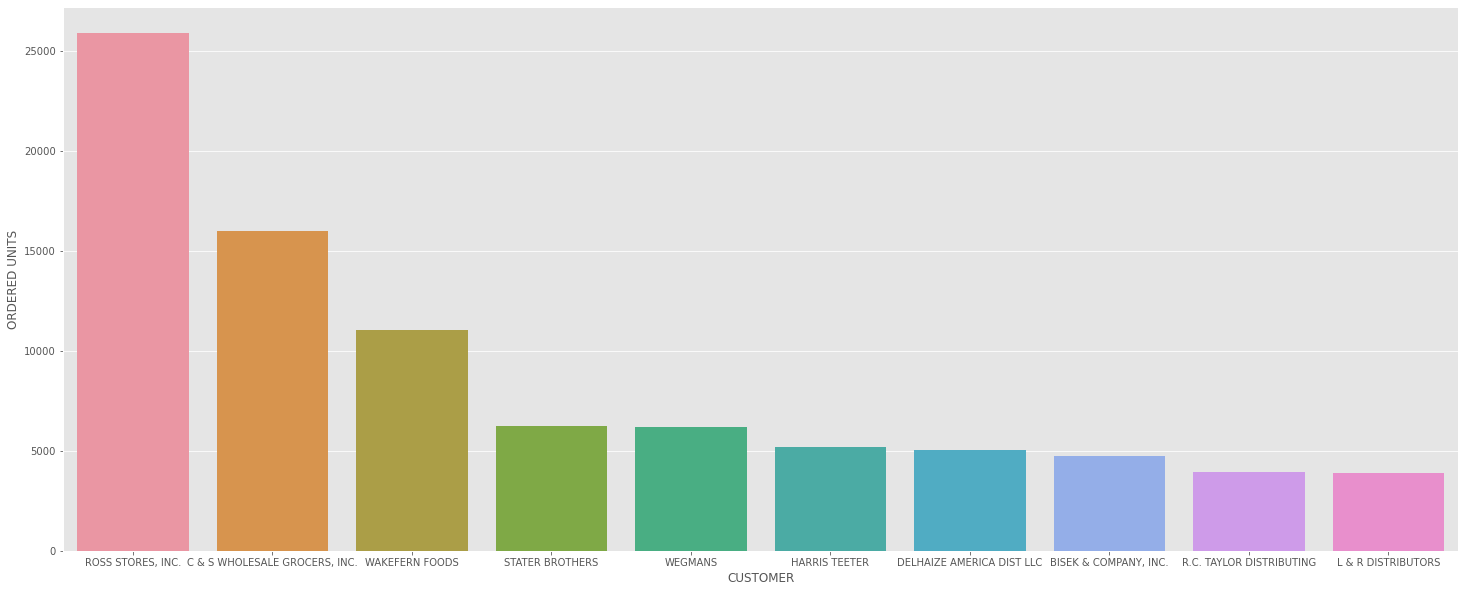

In [15]:
#top 10 

fig,(ax2)= plt.subplots(nrows=1)
fig.set_size_inches(25,10)

sns.barplot(data=cust, x="CUSTOMER", y="ORDERED UNITS", ax=ax2)

In [16]:
# top 10 by order units 
cust

,CUSTOMER,ORDERED UNITS
35,"ROSS STORES, INC.",25872.0
8,"C & S WHOLESALE GROCERS, INC.",15960.0
42,WAKEFERN FOODS,11040.0
38,STATER BROTHERS,6240.0
44,WEGMANS,6168.0
17,HARRIS TEETER,5184.0
15,DELHAIZE AMERICA DIST LLC,5040.0
6,"BISEK & COMPANY, INC.",4728.0
32,R.C. TAYLOR DISTRIBUTING,3960.0
21,L & R DISTRIBUTORS,3864.0


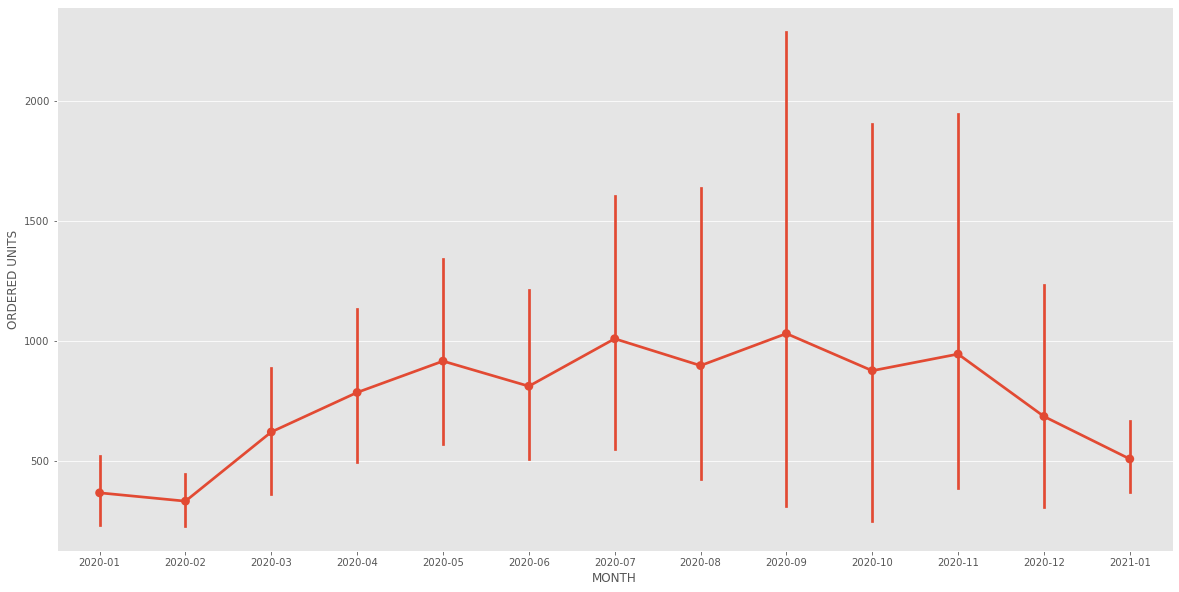

In [17]:
#top10 order trend 

fig,(ax1)= plt.subplots(nrows=1)
fig.set_size_inches(20,10)

sns.pointplot(data=top10, x="MONTH", y="ORDERED UNITS", ax=ax1)

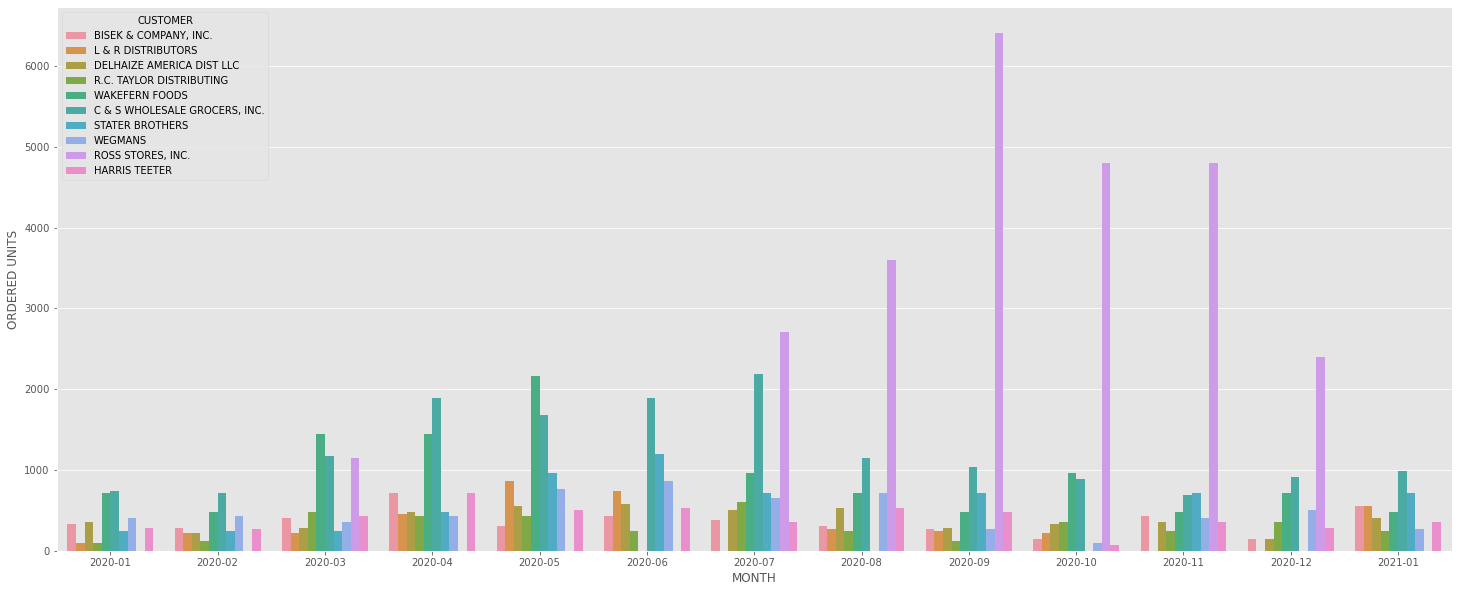

In [18]:
fig,(ax2)= plt.subplots(nrows=1)
fig.set_size_inches(25,10)

sns.barplot(data=top10, x="MONTH", y="ORDERED UNITS", hue="CUSTOMER", ax=ax2)


# December Biggest Misses

In [ ]:
dfDec = df[df["ITEM"].isin(['44152003',
'31296003',
'43124002',
'15136002',
'38217001',
'24117012',
'43692001',
'17417',
'24198003',
'49715001',
'27197001',
'11312002',
'24197002',
'31036002',
'44151002',
'49006003',
'10799002',
'21161001',
'49725',
'21203',
'15779004',
'40037001',
'19034002-SD',
'80113002',
'37312001',
'16030002',
'44176003',
'27119004',
'27214001',
'17433001'])]


dfDec

In [ ]:
dfDec.to_csv (r'C:\Users\amyl\Desktop\DecBiggestMisses.csv', index = False, header=True)

In [ ]:
dfdec_1 = dfDec.groupby('ITEM').sum().reset_index()

dfdec_2 = dfdec_1.sort_values('ORDERED UNITS', ascending=False)
dfdec_2

In [ ]:
dfdec_m = dfDec.groupby('MONTH').sum().reset_index()

dfdec_mm = dfdec_m.sort_values('MONTH', ascending=True)
dfdec_mm

In [ ]:
dfdec_ = dfDec.groupby(['ITEM','MONTH']).sum()
dfdec_1 = dfdec_.sort_values('MONTH', ascending=True)
dfdec_1

In [ ]:
spike = dfdec_[dfdec_["MONTH"].isin(['2020-10','2020-12'])]

In [ ]:

fig,(ax2)= plt.subplots(nrows=1)
fig.set_size_inches(20,10)
plt.xticks(rotation=45)

sns.barplot(data=dfdec_2, x="ITEM", y="ORDERED UNITS", ax=ax2)

In [ ]:
#top10 order trend 

fig,(ax1)= plt.subplots(nrows=1)
fig.set_size_inches(20,10)

#sns.lineplot(data=dfDec, x="MONTH", y="ORDERED UNITS", ax=ax1, sort=False)



sns.pointplot(x='MONTH', y='ORDERED UNITS', data=dfdec_mm, sort=False)

# AO ORDER ANALYSIS

In [158]:
TotalOrder = df.groupby('CUSTOMER').sum().reset_index()
#TotalOrder

In [159]:
# GRAND TOTAL FOR ORDER UNITS 
ORDER_SUM = TotalOrder['ORDERED UNITS'].sum()
ORDER_SUM

5058972.0

In [160]:
#Top 32 customers by order units 
TOP32 = TotalOrder.sort_values('ORDERED UNITS', ascending=False).head(32)
TOP32

,CUSTOMER,ORDERED UNITS
145,SAFEWAY INC.,803690.0
26,"C & S WHOLESALE GROCERS, INC.",436159.0
117,MUNCHKIN.COM,373422.0
171,TJ MAXX,210498.0
142,"ROSS STORES, INC.",198672.0
50,DELHAIZE AMERICA DIST LLC,193092.0
107,MARSHALLS,183639.0
161,"SUPERVALU, INC.",175040.0
13,BABYLIST,159265.0
151,SMART SELLERS LLC,155735.0


In [161]:
TOP32_SUM = TOP32['ORDERED UNITS'].sum()
TOP32_SUM

#4295032/5058972.0 = 0.85 

4295032.0

In [162]:
#GETTING WHOLE DATA ONLY FOR TO0 85 PERCENTILE


df_top85 = df[df["CUSTOMER"].isin(['SAFEWAY INC.',
'C & S WHOLESALE GROCERS, INC.',
'MUNCHKIN.COM',
'TJ MAXX',
'ROSS STORES, INC.',
'DELHAIZE AMERICA DIST LLC',
'MARSHALLS',
'SUPERVALU, INC.',
'BABYLIST',
'SMART SELLERS LLC',
'WAKEFERN FOODS',
'WINCO FOODS, INC.',
'WEGMANS',
'HY-VEE INC.',
'R.C. TAYLOR DISTRIBUTING',
'L & R DISTRIBUTORS',
'KIDDIE STROLLERS WORLD LLC',
'STATER BROTHERS',
'VALU MERCHANDISERS CO',
"VALUE MERCHANDISE INT'L. INC.",
'BISEK & COMPANY, INC.',
'AAFES CROSS DOCK',
'HARRIS TEETER',
'GIANT EAGLE',
'IMPERIAL DISTRIBUTORS',
'AAFES',
'CARDINAL HEALTH PHAR.DIST',
'JUST SHOPPING AROUND',
'BOING GLOBAL S. DE R.L.',
'NEXCOM-EAST',
'DORM BUYS, INC',
'ZULILY, LLC'])]


In [163]:
list(df_top85.columns.values)

['MONTH',
 'ACCT #',
 'ITEM',
 'DESC',
 'CUSTOMER',
 'UOM',
 'CASE SIZE',
 'ORDERED UNITS']

In [179]:
#df_top85.to_excel (r'C:\Users\amyl\Desktop\AO US\oracle_top32.xlsx', index = False, header=True)

In [166]:
# order units by customer in pivot 
# pd.pivot_table(df_top85,index=['CUSTOMER'],columns=['MONTH'],values=['ORDERED UNITS'],aggfunc=np.sum)

In [167]:
#group by items 
items = df_top85.groupby('ITEM').sum().reset_index()

,ITEM,ORDERED UNITS
0,10049PS,288.0
1,10062PS,82.0
2,10062SS,911.0
3,10072001,32040.0
4,10072002,134568.0
...,...,...
1664,PMOD-34349,176.0
1665,PMOD-46760,680.0
1666,PMOD-46764,295.0
1667,PMOD-46765,280.0


In [168]:
#Top 20 items by order units 
top20_items = items.sort_values('ORDERED UNITS', ascending=False).head(20)
top20_items

,ITEM,ORDERED UNITS
349,16030002,388008.0
1138,44152003,165468.0
4,10072002,134568.0
1253,49710-TJX,134322.0
1135,44151002,134016.0
1061,43124002,98904.0
744,24117012,98808.0
773,24198003,94200.0
282,15779004,73566.0
1014,40037001,58704.0


In [ ]:
#example 

In [224]:
df_lookup = df_top85[df_top85["ITEM"].isin(['45062001'])]

In [225]:
df_lookup_pivot = pd.pivot_table(df_lookup,index=['CUSTOMER'],columns=['MONTH'],values=['ORDERED UNITS'],aggfunc=np.sum,margins = True, margins_name='Total')
#df_lookup_pivot.sort_index(ascending=False)
#remove sum,margins = True, margins_name='Total' if only needed to see the individual order units 


df_lookup_pivot

ORDERED UNITS                                                                                                                          
MONTH                               2020-01 2020-02 2020-03 2020-04 2020-05 2020-06 2020-07 2020-08 2020-09  2020-10 2020-11 2020-12 2021-01 2021-02 2021-03    Total
CUSTOMER                                                                                                                                                             
BABYLIST                               72.0    96.0     NaN   408.0   240.0  1248.0  1344.0     NaN     NaN      NaN     NaN   672.0     NaN   600.0     NaN   4680.0
BOING GLOBAL S. DE R.L.                 NaN    48.0   144.0     NaN    24.0     NaN     NaN     NaN     NaN      NaN     NaN     NaN     NaN     NaN     NaN    216.0
C & S WHOLESALE GROCERS, INC.         144.0   288.0  1248.0    48.0  1176.0   336.0   144.0   696.0     NaN    600.0   288.0     NaN   408.0   288.0     NaN   5664.0
DORM BUYS, INC                       1272.0     NaN   240.0     NaN  3744.0   120.0     NaN     NaN  1824.0    552.0     NaN  1896.0     NaN     NaN     NaN   9648.0
HY-VEE INC.                           240.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN      NaN    48.0    24.0     NaN    24.0     NaN    336.0
JUST SHOPPING AROUND                    NaN   720.0   192.0   984.0     NaN     NaN   288.0   360.0     NaN    528.0     NaN     NaN     NaN     NaN     NaN   3072.0
KIDDIE STROLLERS WORLD LLC              NaN     NaN   240.0  1200.0   720.0     NaN     NaN     NaN     NaN      NaN     NaN     NaN     NaN     NaN     NaN   2160.0
SAFEWAY INC.                            NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   9960.0   432.0  3624.0   384.0   432.0     NaN  14832.0
SMART SELLERS LLC                    1128.0   624.0   888.0  2040.0  1248.0   912.0   168.0     NaN     NaN    336.0     NaN     NaN   864.0     NaN     NaN   8208.0
ZULILY, LLC                             NaN    24.0     NaN     NaN     NaN     NaN    24.0    48.0    24.0      NaN    24.0    24.0    48.0     NaN   240.0    456.0
Total                                2856.0  1800.0  2952.0  4680.0  7152.0  2616.0  1968.0  1104.0  1848.0  11976.0   792.0  6240.0  1704.0  1344.0   240.0  49272.0

In [226]:
sum_order_by_items_customer = df_lookup.groupby('CUSTOMER').sum()
sum_order_desc = sum_order_by_items_customer.sort_values('ORDERED UNITS', ascending=False)

grandtotal = np.round(np.sum(sum_order_desc),1)
grandtotal.name = 'Grand Total'
sum_order_desc.append(grandtotal)

,ORDERED UNITS
CUSTOMER,
SAFEWAY INC.,14832.0
"DORM BUYS, INC",9648.0
SMART SELLERS LLC,8208.0
"C & S WHOLESALE GROCERS, INC.",5664.0
BABYLIST,4680.0
JUST SHOPPING AROUND,3072.0
KIDDIE STROLLERS WORLD LLC,2160.0
"ZULILY, LLC",456.0
HY-VEE INC.,336.0
